In [1]:
import torch
import torchvision
from torch import optim
import torchvision.transforms as transforms
import numpy as np
from models import SCrossEntropyLoss, SMLP3, SMLP4, SLeNet, CIFAR, FakeSCrossEntropyLoss
import modules
from qmodels import QSLeNet, QCIFAR
import resnet
import qresnet
import qvgg
import qdensnet
from modules import SModule
from tqdm import tqdm
import time
import argparse
import os
from cw_attack import Attack
import torch
import torch.nn as nn
import torch.optim as optim

def CEval():
    model.eval()
    total = 0
    correct = 0
    model.clear_noise()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            # images = images.view(-1, 784)
            outputs = model(images)
            if len(outputs) == 2:
                outputs = outputs[0]
            predictions = outputs.argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return (correct/total).cpu().numpy()

def NEval(dev_var, write_var):
    model.eval()
    total = 0
    correct = 0
    model.clear_noise()
    with torch.no_grad():
        model.set_noise(dev_var, write_var)
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            # images = images.view(-1, 784)
            outputs = model(images)
            if len(outputs) == 2:
                outputs = outputs[0]
            predictions = outputs.argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return (correct/total).cpu().numpy()

def NEachEval(dev_var, write_var):
    model.eval()
    total = 0
    correct = 0
    model.clear_noise()
    with torch.no_grad():
        for images, labels in testloader:
            model.clear_noise()
            model.set_noise(dev_var, write_var)
            images, labels = images.to(device), labels.to(device)
            # images = images.view(-1, 784)
            outputs = model(images)
            if len(outputs) == 2:
                outputs = outputs[0]
            predictions = outputs.argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return (correct/total).cpu().numpy()

def NTrain(epochs, header, dev_var=0.0, write_var=0.0, verbose=False):
    best_acc = 0.0
    for i in range(epochs):
        model.train()
        running_loss = 0.
        # for images, labels in tqdm(trainloader):
        for images, labels in trainloader:
            model.clear_noise()
            model.set_noise(dev_var, write_var)
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            # images = images.view(-1, 784)
            outputs = model(images)
            loss = criteriaF(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # test_acc = NEachEval(dev_var, write_var)
        test_acc = CEval()
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f"tmp_best_{header}.pt")
        if verbose:
            print(f"epoch: {i:-3d}, test acc: {test_acc:.4f}, loss: {running_loss / len(trainloader):.4f}")
        scheduler.step()

def str2bool(a):
    if a == "True":
        return True
    elif a == "False":
        return False
    else:
        raise NotImplementedError(f"{a}")


In [43]:
parser = argparse.ArgumentParser()
parser.add_argument('--train_epoch', action='store', type=int, default=20,
        help='# of epochs of training')
parser.add_argument('--noise_epoch', action='store', type=int, default=100,
        help='# of epochs of noise validations')
parser.add_argument('--train_var', action='store', type=float, default=0.0,
        help='device variation [std] when training')
parser.add_argument('--dev_var', action='store', type=float, default=0.3,
        help='device variation [std] before write and verify')
parser.add_argument('--write_var', action='store', type=float, default=0.03,
        help='device variation [std] after write and verify')
parser.add_argument('--mask_p', action='store', type=float, default=0.01,
        help='portion of the mask')
parser.add_argument('--device', action='store', default="cuda:0",
        help='device used')
parser.add_argument('--verbose', action='store', type=str2bool, default=False,
        help='see training process')
parser.add_argument('--model', action='store', default="MLP4", choices=["MLP3", "MLP4", "LeNet", "CIFAR", "Res18", "TIN", "QLeNet", "QCIFAR", "QRes18", "QDENSE", "QTIN", "QVGG"],
        help='model to use')
parser.add_argument('--method', action='store', default="SM", choices=["second", "magnitude", "saliency", "random", "SM"],
        help='method used to calculate saliency')
parser.add_argument('--alpha', action='store', type=float, default=1e6,
        help='weight used in saliency - substract')
parser.add_argument('--header', action='store',type=int, default=1,
        help='use which saved state dict')
parser.add_argument('--pretrained', action='store',type=str2bool, default=True,
        help='if to use pretrained model')
parser.add_argument('--use_mask', action='store',type=str2bool, default=True,
        help='if to do the masking experiment')
parser.add_argument('--model_path', action='store', default="./pretrained",
        help='where you put the pretrained model')
parser.add_argument('--save_file', action='store',type=str2bool, default=True,
        help='if to save the files')
parser.add_argument('--calc_S', action='store',type=str2bool, default=True,
        help='if calculated S grad if not necessary')
parser.add_argument('--div', action='store', type=int, default=1,
        help='division points for second')
parser.add_argument('--layerwise', action='store',type=str2bool, default=False,
        help='if do it layer by layer')
args = parser.parse_args("")

print(args)
header = time.time()
header_timer = header
parent_path = "./"

device = torch.device(args.device if torch.cuda.is_available() else "cpu")

BS = 128

trainset = torchvision.datasets.MNIST(root='~/Private/data', train=True,
                                        download=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                        shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='~/Private/data', train=False,
                                    download=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BS,
                                            shuffle=False, num_workers=2)
model = SLeNet()
# model = QSLeNet()

model.to(device)
model.push_S_device()
model.clear_noise()
model.clear_mask()
criteria = SCrossEntropyLoss()
criteriaF = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [60])

Namespace(alpha=1000000.0, calc_S=True, dev_var=0.3, device='cuda:0', div=1, header=1, layerwise=False, mask_p=0.01, method='SM', model='MLP4', model_path='./pretrained', noise_epoch=100, pretrained=True, save_file=True, train_epoch=20, train_var=0.0, use_mask=True, verbose=False, write_var=0.03)


In [30]:
# args.train_epoch = 20
# args.dev_var = 0.3
# args.train_var = 0.0
# args.verbose = True

# model.to_first_only()
# NTrain(args.train_epoch, header, args.train_var, 0.0, args.verbose)
# if args.train_var > 0:
#     state_dict = torch.load(f"tmp_best_{header}.pt")
#     model.load_state_dict(state_dict)
# model.from_first_back_second()
# torch.save(model.state_dict(), f"saved_B_{header}.pt")
# print(f"No mask no noise: {CEval():.4f}")

# state_dict = torch.load(f"saved_B_{header}.pt")
# model.load_state_dict(state_dict)
# model.clear_mask()

# performance = NEachEval(args.dev_var, 0.0)
# print(f"No mask noise acc: {performance:.4f}")

In [44]:
header = 1
state_dict = torch.load(f"saved_B_{header}.pt")
model.load_state_dict(state_dict)
model.clear_mask()
print(f"No mask no noise: {CEval():.4f}")
model.to_first_only()

No mask no noise: 0.9902


In [83]:
class WCW(Attack):
    def __init__(self, model, c=1e-4, kappa=0, steps=1000, lr=0.01):
        super().__init__("CW", model)
        self.model = model
        self.c = c
        self.kappa = kappa
        self.steps = steps
        self.lr = lr
        self._supported_mode = ['default', 'targeted']
    
    def get_noise(self):
        w = []
        for m in self.model.modules():
            if isinstance(m, modules.NModule) or isinstance(m, modules.SModule):
                m.noise.requires_grad_()
                w.append(m.noise)
        return w
    
    def noise_l2(self):
        size = 0
        w = 0
        for m in self.model.modules():
            if isinstance(m, modules.NModule) or isinstance(m, modules.SModule):
                w += m.noise.pow(2).sum().item()
                size += len(m.noise.view(-1))
        return w / size

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self._targeted:
            target_labels = self._get_target_label(images, labels)

        best_adv_images = images.clone().detach()
        best_L2 = 1e10*torch.ones((len(images))).to(self.device)
        prev_cost = 1e100
        dim = len(images.shape)

        MSELoss = nn.MSELoss(reduction='none')
        Flatten = nn.Flatten()
        w = self.get_noise()
        current_L2 = self.noise_l2()
        

        optimizer = optim.Adam(w, lr=self.lr, weight_decay=self.c)

        for step in range(self.steps):

            outputs = self.model(images)
            if self._targeted:
                f_loss = self.f(outputs, target_labels).sum()
            else:
                f_loss = self.f(outputs, labels).sum()

            cost = self.c*f_loss

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            # Update adversarial images
            # _, pre = torch.max(outputs.detach(), 1)
            # correct = (pre == labels).float()

            # # filter out images that get either correct predictions or non-decreasing loss, 
            # # i.e., only images that are both misclassified and loss-decreasing are left 
            # mask = (1-correct)*(best_L2 > current_L2.detach())
            # best_L2 = mask*current_L2.detach() + (1-mask)*best_L2

            # mask = mask.view([-1]+[1]*(dim-1))
            # best_adv_images = mask*adv_images.detach() + (1-mask)*best_adv_images

            # # Early stop when loss does not converge.
            # # max(.,1) To prevent MODULO BY ZERO error in the next step.
            # if step % max(self.steps//10,1) == 0:
            #     if cost.item() > prev_cost:
            #         return best_adv_images
            #     prev_cost = cost.item()

        # return best_adv_images

    def tanh_space(self, x):
        return 1/2*(torch.tanh(x) + 1)

    def inverse_tanh_space(self, x):
        # torch.atanh is only for torch >= 1.7.0
        return self.atanh(x*2-1)

    def atanh(self, x):
        return 0.5*torch.log((1+x)/(1-x))

    # f-function in the paper
    def f(self, outputs, labels):
        one_hot_labels = torch.eye(len(outputs[0]))[labels].to(self.device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1) # get the second largest logit
        j = torch.masked_select(outputs, one_hot_labels.bool()) # get the largest logit

        if self._targeted:
            return torch.clamp((i-j), min=-self.kappa)
        else:
            return torch.clamp((j-i), min=-self.kappa)

In [90]:
model.clear_noise()
attacker = WCW(model, c=1, kappa=0, steps=1000, lr=5e-5)
attacker.set_mode_targeted_random(n_classses=10)
images, labels = iter(testloader).next()
images, labels = images.to(device), labels.to(device)
adv_examples = attacker(images, labels)

Attack mode is changed to 'targeted(random).'


In [91]:
w = attacker.get_noise()
m = []
for mm in w:
    m.append(mm.max().item())
print(max(m))
print(attacker.noise_l2())

0.08332809060811996
0.00023530688487545786


In [89]:
predicted = model(images).argmax(dim=1)
print((predicted == labels).sum() / len(predicted))

tensor(0.1172, device='cuda:0')


In [8]:
a = adv_examples[18].cpu().numpy().reshape(28,28)
o = images[18].cpu().numpy().reshape(28,28)

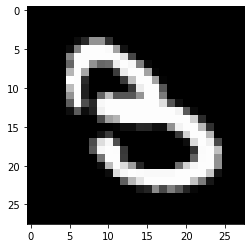

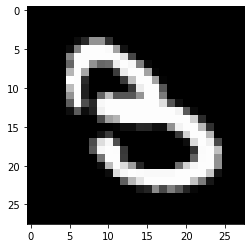

In [10]:
from matplotlib import pyplot as plt
plt.imshow(a, cmap="gray")
plt.show()
plt.imshow(o, cmap="gray")